 ## Python Implementation

In [182]:
#Let's start with importing necessary libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score 

In [186]:
import sklearn as sk
sk.__version__

'0.21.3'

In [192]:
pd.__version__

'0.25.1'

In [194]:
np.__version__

'1.16.5'

In [191]:
!python -V

Python 3.7.4


In [180]:
scikit-learn.__version__

NameError: name 'scikit' is not defined


### Load dataset

In [144]:
data = sm.datasets.fair.load_pandas().data
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [145]:
#Defining new column('affair') which signifies 0-dont have affair; 1- have affair
data['affair'] = (data.affairs>0).astype(int)
data.drop(['affairs'],axis=1,inplace=True)
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


#### Get Label and Features columns

In [146]:

y=data['affair']
X=data.drop(['affair'],axis=1)


In [147]:
#Check Null values
data.isnull().sum()
data.occupation.value_counts()

3.0    2783
4.0    1834
2.0     859
5.0     740
6.0     109
1.0      41
Name: occupation, dtype: int64

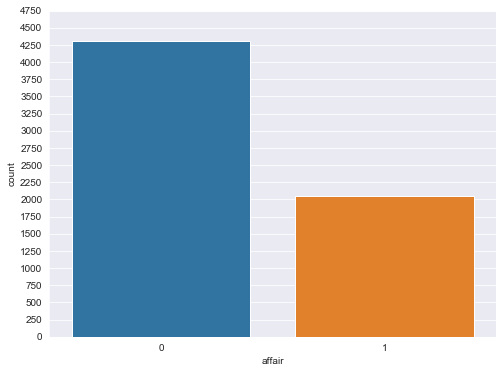

In [148]:
#Count of each class
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(data['affair'])
plt.yticks(range(0,5000,250))
plt.show()

#its evident that class 0 has majority data points.We need to handle this by upsampling.

#### Study relationship between Label and features

Text(0, 0.5, 'Frequency')

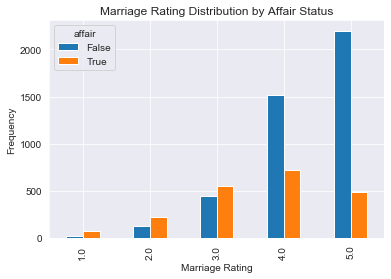

In [149]:
#Marriage Rating distribution for women having affairs as compared to th
pd.crosstab(X.rate_marriage, y.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

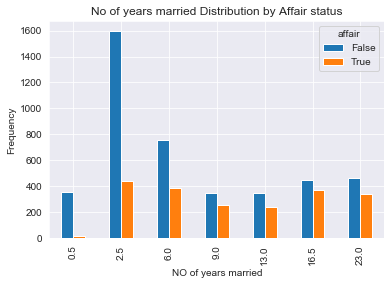

In [150]:
#How number of years married affects the affair status
pd.crosstab(X.yrs_married, y.astype(bool)).plot(kind='bar')
plt.title('No of years married Distribution by Affair status')
plt.xlabel('NO of years married')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

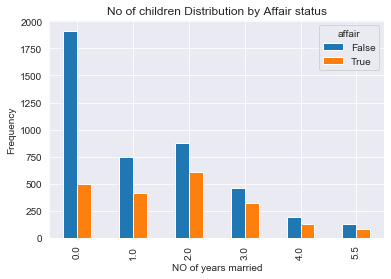

In [151]:
#How number of children affects Affair status
pd.crosstab(X.children, y.astype(bool)).plot(kind='bar')
plt.title('No of children Distribution by Affair status')
plt.xlabel('NO of years married')
plt.ylabel('Frequency')


#### Seggregate Numerical and Categorical columns which will be used in Data pre processing before feeding into the model

In [152]:
X['occupation']=X['occupation'].astype('object')
X['occupation_husb']=X['occupation_husb'].astype('object')
#get nmericalcols
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes('object').columns.tolist()
print("Numerical columns are",numeric_cols)
print("Categorical columns are",categorical_cols)
#toarray()

Numerical columns are ['rate_marriage', 'age', 'yrs_married', 'children', 'religious', 'educ']
Categorical columns are ['occupation', 'occupation_husb']


### Split the dataset

In [153]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size= 0.20, random_state = 355)

### Data preprocessing before training the model

#### MinMax scalar for numerical columns

In [154]:
scalar=MinMaxScaler()
scalar.fit(x_train[numeric_cols])



MinMaxScaler(copy=True, feature_range=(0, 1))

In [155]:
#Transform Numerical Columns
x_train[numeric_cols] = scalar.transform(x_train[numeric_cols])
x_test[numeric_cols] = scalar.transform(x_test[numeric_cols])


#### One hot encoding for Categorical columns

In [156]:
#Transform Categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(x_train[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)


['occupation_1.0', 'occupation_2.0', 'occupation_3.0', 'occupation_4.0', 'occupation_5.0', 'occupation_6.0', 'occupation_husb_1.0', 'occupation_husb_2.0', 'occupation_husb_3.0', 'occupation_husb_4.0', 'occupation_husb_5.0', 'occupation_husb_6.0']


In [157]:
#Create new columns for the encoded columns generated above using OneHotEncode
for i in encoded_cols:
    x_train[i] =np.nan
    x_test[i]=np.nan
#x_test[encoded_cols] = encoder.transform(x_test[categorical_cols])

In [158]:
x_train[encoded_cols]=encoder.transform(x_train[categorical_cols])
x_test[encoded_cols]=encoder.transform(x_test[categorical_cols])

In [159]:
x_train.drop(['occupation','occupation_husb'],axis=1,inplace=True)
x_test.drop(['occupation','occupation_husb'],axis=1,inplace=True)

###  Model Creation

In [160]:
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Performance metrics of the model


In [161]:
y_pred = log_reg.predict(x_test)
y_pred[0:5]

array([1, 0, 0, 0, 0])

In [162]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy of the model is", round(accuracy*100,2) ,"%")

Accuracy of the model is 72.14 %


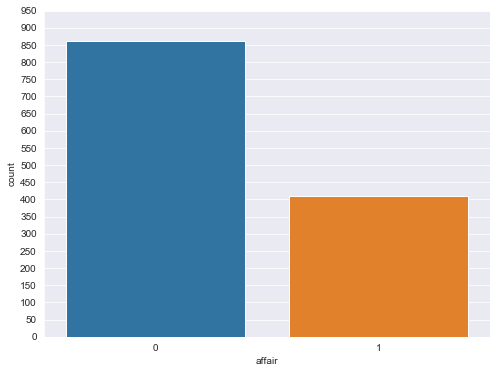

In [163]:
#Count of each class in Test set
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
sns.countplot(y_test)
plt.yticks(range(0,1000,50))
plt.show()

In [164]:
# Confusion Matrix
conf_matrix= confusion_matrix(y_test,y_pred)
conf_matrix

array([[776,  87],
       [268, 143]], dtype=int64)

In [165]:
true_positive = conf_matrix[1][1]
false_positive = conf_matrix[0][1]
false_negative = conf_matrix[1][0]
true_negative = conf_matrix[0][0]
print("True Positive",true_positive)
print("False Positive",false_positive)
print("False Negative",false_negative)
print("True Negative",true_negative)
print("Total postive class",true_positive+false_negative)
print("Total negative class",true_negative+false_positive)

True Positive 143
False Positive 87
False Negative 268
True Negative 776
Total postive class 411
Total negative class 863


In [166]:
# Calculate precision-Out of all predicted postive points,How many were actually positive.
precision = true_positive/(true_positive+false_positive)
print("Precision of Model is",round(precision,2)*100,"%")

Precision of Model is 62.0 %


In [167]:
# Calculate Recall/Sensitivity-Out of all postive class how many were correctly predicted as positive 
recall = true_positive/(true_positive+false_negative)
print("Recall/Sensitivity of Model is",round(recall,2)*100,"%")

Recall/Sensitivity of Model is 35.0 %


In [168]:
# F1 Score
f1_score = 2*(recall * precision) / (recall + precision)
print("F1 score of the model is",round(f1_score,2)*100,"%")
#Overall Model is not performing well. WE will try other models to do the job

F1 score of the model is 45.0 %


### Predict Single Data Point. The following data point will come from WEB API in JSON format as shown below

In [175]:
#JSON format for the API
#{"features":{"rate_marriage":3,"age":32,"yrs_married":9,"children":3,"religious":3,"educ":17,"occupation":1,"occupation_husb":4}}

In [169]:
#Predict SIngle data point
dict1={"rate_marriage":3,"age":32,"yrs_married":9,"children":3,"religious":3,"educ":17,"occupation":1,"occupation_husb":4}


In [170]:
#Seggregate the numerical and categorical columns
numeric=np.array([])
categorical=np.array([])
for index,val in dict1.items():
    if index in numeric_cols:
        numeric=np.append(numeric,val)
    else:
        categorical=np.append(categorical,val)

In [171]:
#Transform both numerical and categorical columns
numArray=scalar.transform(numeric.reshape(1,-1)).reshape(-1)
catArray=encoder.transform(categorical.reshape(1,-1)).reshape(-1)
print("MinMax scaling of numerical columns",numArray)
print("OneHOt encoding of Categorical columns",catArray) 

MinMax scaling of numerical columns [0.5        0.59183673 0.37777778 0.54545455 0.66666667 0.72727273]
OneHOt encoding of Categorical columns [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [172]:
#Append both the columns so that we can pass thw data to the model 
finalInput=np.concatenate((numArray,catArray))
finalInput.reshape(1,-1)

array([[0.5       , 0.59183673, 0.37777778, 0.54545455, 0.66666667,
        0.72727273, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        ]])

In [173]:
#Predict the above data point
predictedVal=log_reg.predict(finalInput.reshape(1,-1))
print("Predicted class is",predictedVal[0] ,"which means Women will not have affair")

Predicted class is 0 which means Women will not have affair


### Store the Model

In [174]:
import pickle
# Writing different model files to file
with open( 'logregModel.sav', 'wb') as f:
    pickle.dump(log_reg,f)
    
with open('minMaxScalar.sav', 'wb') as f:
    pickle.dump(scalar,f)
    
with open('oneHotEncoder.sav', 'wb') as f:
    pickle.dump(encoder,f)

### Use the model as API

#### Model I/p:
<img src="modelIp.PNG" width= "1000">

#### Model O/p:
<img src="modelOp.PNG" width= "1000">